<a href="https://colab.research.google.com/github/m3sibti/DL_projects/blob/master/Keras_Segmentation_UNet_mw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

## Imports

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Download the dataset

In [2]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  87.7M      0  0:00:08  0:00:08 --:--:-- 89.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  64.6M      0 --:--:-- --:--:-- --:--:-- 64.3M


## Prepare the dataset

### Load their paths

Set the parameters

In [0]:
input_dir = 'images/'
target_dir = 'annotations/trimaps/'
image_size = (160, 160)
num_class = 4
batch_size = 32

Prepare the paths

In [0]:
input_img_paths = sorted([
                             os.path.join(input_dir, fname)
                             for fname in os.listdir(input_dir)
                             if fname.endswith('.jpg')
])

target_img_paths = sorted([
                             os.path.join(target_dir, fname)
                             for fname in os.listdir(target_dir)
                             if fname.endswith('.png') and not fname.startswith('.')
])

In [9]:
print('Number of Samples ', len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
  print(f'{input_path} | {target_path}')

Number of Samples  7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


### Split the Validation Split

In [0]:
import random

Shuffle the dataset

In [0]:
val_sample = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1137).shuffle(target_img_paths)

Split into two parts

In [0]:
train_input_img_path = input_img_paths[:-val_sample]
train_target_img_path = target_img_paths[:-val_sample]

valid_input_img_path = input_img_paths[-val_sample:]
valid_target_img_path = target_img_paths[-val_sample:]

### Visualize the dataset 

Imports for this

In [0]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps
from tensorflow.keras.preprocessing.image import load_img

Display the images and their corresponding masks

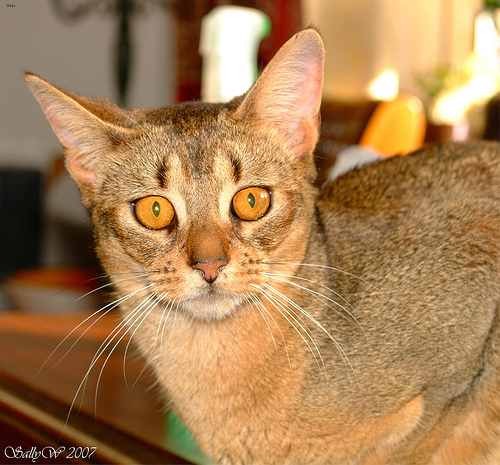

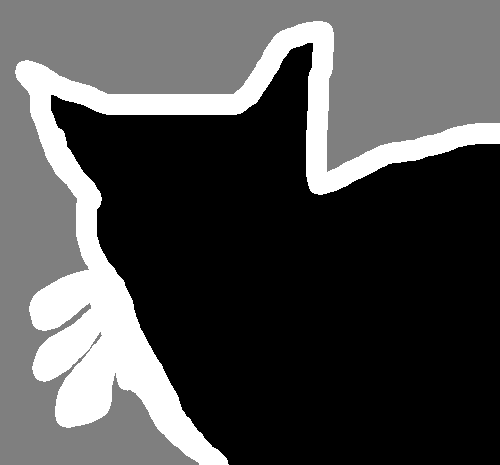

In [11]:
display(Image(filename=input_img_paths[4]))
print('')
img = ImageOps.autocontrast(load_img(target_img_paths[4]))
display(img)

### A Custom Dataset Class

In [0]:
class OxfordPets(keras.utils.Sequence):
  # Help to iterate over dataset as numpy

  def __init__(self, batch_size, img_size, i_paths, t_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.i_paths = i_paths
    self.t_paths = t_paths

  def __len__(self):
    return len(self.t_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    
    # perform batching
    batch_i_paths = self.i_paths[i: i + self.batch_size]
    batch_t_paths = self.t_paths[i: i + self.batch_size]

    # prepare inputs
    x = np.zeros((self.batch_size,) + self.img_size +(3,), dtype='float32')
    for j, path in enumerate(batch_i_paths):
      i_img = load_img(path, target_size=self.img_size)
      x[j] = i_img

    # prepare targets
    y = np.zeros((self.batch_size,) + self.img_size +(1,), dtype='uint8')
    for j, path in enumerate(batch_t_paths):
      t_img = load_img(path, target_size=self.img_size, color_mode='grayscale')
      y[j] = np.expand_dims(t_img,2)
    
    return x, y

## Prepare Model

In [0]:
def get_model(img_size, n_classes):
  inputs = keras.Input(shape=img_size + (3,))

  # first downsample the inputs
  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block = x  # for residuals

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # project residual block
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(
        previous_block
    )
    x = layers.add([x, residual])
    previous_block = x

  previous_block = x

  # second decoder part
  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    # residual
    residual = layers.UpSampling2D(2)(previous_block)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    previous_block = x


  outputs = layers.Conv2D(n_classes, 3, activation='softmax',
                          padding='same')(x)
  
  model = keras.Model(inputs, outputs)
  return model


Clear Memory

In [0]:
keras.backend.clear_session()

Initialize Model

In [0]:
model = get_model(image_size, num_class)

### Model Summary

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Model Architecture

In [0]:
keras.utils.plot_model(model)

## Prepate DataGenerators

In [0]:
train_gen = OxfordPets(batch_size, image_size, train_input_img_path, train_target_img_path)
valid_gen = OxfordPets(batch_size, image_size, valid_input_img_path, valid_target_img_path)

## Train the Model

Clear Memory before fitting your model

Compile the Model

In [0]:
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy'
)

cbks = keras.callbacks.ModelCheckpoint('oxford_seg.h5', save_best_only=True)

Fit the Model

In [0]:
epochs = 15

In [35]:
model.fit(train_gen,
          validation_data=valid_gen,
          epochs=epochs, callbacks=[cbks])

Epoch 1/15
199/199 [==============================] - 82s 413ms/step - loss: 1.2488 - val_loss: 1.4719
Epoch 2/15
199/199 [==============================] - 81s 408ms/step - loss: 0.7818 - val_loss: 1.0348
Epoch 3/15
199/199 [==============================] - 82s 411ms/step - loss: 0.7689 - val_loss: 0.7747
Epoch 4/15
199/199 [==============================] - 82s 410ms/step - loss: 0.7621 - val_loss: 1.0845
Epoch 5/15
199/199 [==============================] - 82s 410ms/step - loss: 0.7584 - val_loss: 0.7618
Epoch 6/15
199/199 [==============================] - 81s 409ms/step - loss: 0.7556 - val_loss: 0.7694
Epoch 7/15
199/199 [==============================] - 82s 411ms/step - loss: 0.7530 - val_loss: 0.7590
Epoch 8/15
199/199 [==============================] - 81s 409ms/step - loss: 0.7509 - val_loss: 0.7639
Epoch 9/15
199/199 [==============================] - 82s 410ms/step - loss: 0.7474 - val_loss: 0.7649
Epoch 10/15
199/199 [==============================] - 82s 410ms/step - l

## Visualize Predictions

Function for visualization

In [0]:
def display_mask(preds, i):
  mask = np.argmax(preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)

Get some predictions

In [0]:
valid_gen = OxfordPets(batch_size, image_size, valid_input_img_path, valid_target_img_path)
valid_preds = model.predict(valid_gen)

Display Image, GT-Mask and Predicted Mask

In [0]:
i = 10

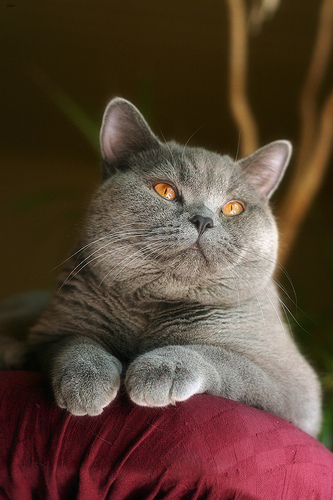

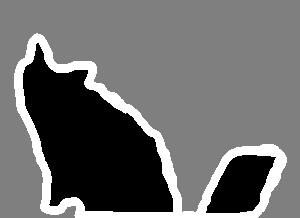

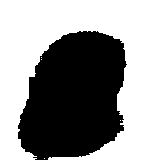

In [41]:
display(Image(filename=valid_input_img_path[i]))
print('')
img = PIL.ImageOps.autocontrast(load_img(valid_target_img_path[i]))
display(img)
print('')
display_mask(valid_preds, i)